# 05-Surface Photometry

References:
* [Jedrzejewski 1987](https://academic.oup.com/mnras/article/226/4/747/1003560)
* [Ciambur et al. 2015 (ISOFIT)](https://iopscience.iop.org/article/10.1088/0004-637X/810/2/120/meta)
* [Peng et al. 2010 (GALFIT)](https://iopscience.iop.org/article/10.1088/0004-6256/139/6/2097)


* [SNU_AOclass Notebook - Extended Sources](https://github.com/ysBach/SNU_AOclass/blob/master/Notebooks/06-Extended_Sources.ipynb)


* [`photutils.isofit` Documentation](https://photutils.readthedocs.io/en/stable/isophote.html)
* [Elliptical Isophote Analysis](https://photutils.readthedocs.io/en/stable/isophote.html)
* [API for EllipseGeometry](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html)
* [API for Ellipse](https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Ellipse.html)


<div class="alert alert-block alert-warning">
이 노트북을 실행했을 때 메모리를 많이 차지하는 것을 확인했습니다 (약 2GB 이상). 왜 그런지는 조금 더 들여다 봐야할 것 같은데 직접 사용할  일이 없으신 분들은 과정만 봐 주시고 굳이 실행할 필요는 없습니다.
</div>

## Notebook Setup

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, ysfitsutilpy, ysphotutilpy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2022-05-10 17:08:47 (GMT+0900) 
0 Python     3.9.12 64bit [Clang 12.0.0 ]
1 IPython    7.31.1
2 OS         macOS 10.16 x86_64 i386 64bit
3 astropy    5.0.4
4 numpy      1.21.2
5 scipy      1.7.3
6 matplotlib 3.5.1
7 astroquery 0.4.7.dev7672
8 ccdproc    2.3.0
9 photutils  1.4.0
10 ysfitsutilpy 0.2.dev0
11 ysphotutilpy 0.0.2.dev0
12 version_information 1.0.4


## Importing Packages

In [4]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import SigmaClip
from astroquery.sdss import SDSS

from matplotlib import pyplot as plt
from matplotlib import rcParams

from photutils.isophote import EllipseGeometry, Ellipse
from photutils.isophote import build_ellipse_model
from photutils.aperture import SkyCircularAperture as SCAp
from photutils.aperture import SkyCircularAnnulus as SCAn
from photutils.aperture import aperture_photometry, ApertureStats

from scipy.optimize import curve_fit

rcParams.update({'font.size':12})

## Path Setup

In [6]:
DATADIR = Path('../data/example')
NAME = 'M89'
imglist = list(DATADIR.glob('m89_[gr].fits'))
imglist.sort()
print(imglist)

interval = ZScaleInterval() # for zscale image plot

[PosixPath('../data/example/m89_g.fits'), PosixPath('../data/example/m89_r.fits')]


## Define Functions and Class

In [7]:
def sersic(r, mu_eff, r_eff, n):
    bn = 2 * n - 1/3
    return mu_eff + (2.5 * bn / np.log(10)) * ((r / r_eff)**(1/n) - 1)


def sersic_flux(r, Ie, re, n):
    return Ie*np.exp(-(2*n-1/3)*((r/re)**(1./n)-1))


def double_sersic(r, Ie1, re1, n1, Ie2, re2, n2):
    I = sersic_flux(r, Ie1, re1, n1) + sersic_flux(r, Ie2, re2, n2)
    return 22.5 - 2.5*np.log10(I)


class SloanGalaxySurfacePhot:
    def __init__(self, imgpath, sky_r0, pixel_scale, name='',
                 band='', mag0=22.5):
        self.imgpath = imgpath
        self.sky_r0 = sky_r0
        self.pixel_scale = pixel_scale
        self.mag0 = mag0
        self.name = name
        self.band = band
        
    def set_image(self, ext=0, display=True, vmax=0.7):
        self.img, self.hdr = fits.getdata(self.imgpath, header=True, ext=ext)
        self.wcs = WCS(self.hdr)
        self.x_center, self.y_center = np.array(self.img.shape)/2
        
        r0 = self.sky_r0   # outer boundary for sky estimation

        # --- Background estimation for determining backgroun level --- #

        x1d = np.arange(0, self.img.shape[1], 1)
        y1d = np.arange(0, self.img.shape[0], 1)
        xx, yy = np.meshgrid(x1d, y1d, sparse=True)
        z = ((xx-self.x_center)**2.0 + (yy-self.y_center)**2.0 - r0**2.0)
        self.sky_region = (z > 0.0)

        avg, med, std = sigma_clipped_stats(self.img[self.sky_region],
                                            sigma=3.0)
        self.sky_val, self.sky_sig = 3.0*med - 2.0*avg, std
        print("Image: "+self.imgpath.stem)
        print("sky level: {0:.4f}".format(self.sky_val))
        print("sky sigma: {0:.4f}".format(self.sky_sig))
        # ---------- #
        if display:
            fig, ax = plt.subplots(figsize=(5, 5))
            vmin, _vmax = interval.get_limits(self.img)
            vmax = vmax if vmax else _vmax
            vlimits = {'vmin': vmin, 'vmax': vmax}
            ax.imshow(self.img, origin='lower', **vlimits)
            ax.imshow(self.sky_region, origin='lower', alpha=0.2, cmap='gray')
            plt.title(f'{self.name} ({self.band}-band)')
        
    def set_kwargs_simple(self, rmax=1000.):
        kwargs = {"x0":self.x_center-1, "y0":self.y_center-1, 'pa':np.pi/2,
                  "eps":0.05, "sma":5.0, "linear_growth":False,
                  "astep":0.05, "fix_center":False, "fix_eps":False, "fix_pa":False}
        self.kwargs = kwargs
        
    def set_kwargs(self, kwargs):
        self.kwargs = kwargs
        
    def ellipse(self, display=True, model_path=None, residual_path=None,
                backgr=True, minsma=0.05, maxsma=1000., nclip=2, **kwargs):
        start_time = time.time()
        
        basedir = self.imgpath.parent
        imgname = self.imgpath.stem    # image name
        if (model_path is None):
            model_path = basedir/(imgname+'_mod.fits')    # output model path
        if (residual_path is None):
            residual_path = basedir/(imgname+'_res.fits') # output resid path

        # running photutils/ellipse task
        g = EllipseGeometry(**self.kwargs)
        ellipse = Ellipse(self.img, geometry=g)
        
        backgr_level = self.sky_val if backgr else 0
        
        isolist = ellipse.fit_image(sma0=self.kwargs['sma'],
                                    step=self.kwargs['astep'], nclip=nclip,
                                    minsma=minsma, maxsma=maxsma,
                                    maxrit=maxsma, **kwargs)
        
        # Making model, residual images
        model = build_ellipse_model(self.img.shape, isolist, fill=backgr_level)
        residual = self.img - model
        fits.writeto(model_path, model, overwrite=True)
        fits.writeto(residual_path, residual, overwrite=True)

        end_time = time.time()
        print(f'Elapsed time : {(end_time - start_time)/60:.2f} min '+
              f'({end_time - start_time:.2f} sec)')
        self.isolist = isolist
        self.model = model
        self.residual = residual
        
        if display:
            self.display_omr()
        
    def display_omr(self, vmax=0.7):
        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
        fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
        vmin, _vmax = interval.get_limits(self.img)
        vmax = vmax if vmax else _vmax
        vlimits = {'vmin': vmin, 'vmax': vmax}
        ax1.imshow(self.img, origin='lower', **vlimits)
        ax1.set_title('Data')

        smas = np.linspace(100, 500, 5)
        for sma in smas:
            iso = self.isolist.get_closest(sma)
            x, y, = iso.sampled_coordinates()
            ax1.plot(x, y, color='g', lw=1)

        ax2.imshow(self.model, origin='lower', **vlimits)
        ax2.set_title('Ellipse Model')

        ax3.imshow(self.residual, origin='lower', **vlimits)
        ax3.set_title('Residual')
        ax3.text(0.95, 0.05, f'{self.name} ({self.band}-band)', ha='right',
                 transform=ax3.transAxes, c='w', fontweight='bold')
        return ax1, ax2, ax3
        
    def set_ref_stars(self, maglimit=16, display=True):
        bnds = self.wcs.pixel_to_world([0,self.wcs.array_shape[0]],
                                       [0,self.wcs.array_shape[1]])
        ra_bnds = np.sort(bnds.ra.value)
        dec_bnds = np.sort(bnds.dec.value)
        self.sql_query = f'''
            SELECT u,g,r,i,z,ra,dec, flags_r
            FROM Star
            WHERE
            ra BETWEEN {ra_bnds[0]} and {ra_bnds[1]}
            AND dec BETWEEN {dec_bnds[0]} and {dec_bnds[1]}
            AND ((flags_r & 0x10000000) != 0)
            -- detected in BINNED1
            AND ((flags_r & 0x8100000c00a4) = 0)
            -- not EDGE, NOPROFILE, PEAKCENTER, NOTCHECKED, PSF_FLUX_INTERP,
            -- SATURATED, or BAD_COUNTS_ERROR
            AND (((flags_r & 0x400000000000) = 0) or (psfmagerr_r <= 0.2))
            -- not DEBLEND_NOPEAK or small PSF error
            -- (substitute psfmagerr in other band as appropriate)
            AND (((flags_r & 0x100000000000) = 0) or (flags_r & 0x1000) = 0)
            -- not INTERP_CENTER or not COSMIC_RAY
            AND g < {maglimit}
            AND r < {maglimit}
            '''
        self.star_table = SDSS.query_sql(self.sql_query, timeout=9999)
        self.co_star = SkyCoord(ra=self.star_table['ra'],
                               dec=self.star_table['dec'], unit='deg')
        
        if display:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111, projection=self.wcs)
            vmin, vmax = interval.get_limits(self.img)
            vlimits = {'vmin': vmin, 'vmax': 0.7}
            ax.imshow(self.img, origin='lower', **vlimits)
            ax.scatter(self.co_star.ra.value, self.co_star.dec.value, ec='r',
                       fc='none', transform=ax.get_transform('world'))
        
    def apphot_stars(self, display=True):
        # initial apertures to obtain fwhm
        aperture_init = SCAp(self.co_star, r=4. * u.arcsec)
        aperstats = ApertureStats(self.img, aperture_init, wcs=self.wcs)
        
        fwhm = aperstats.fwhm.mean() / u.pix * u.arcsec * self.pixel_scale
        r_ap = 2 * fwhm
        r_in = 4 * fwhm
        r_out = 6 * fwhm
        self.fwhm = fwhm
        
        # define new apertures with derived fwhm
        aperture = SCAp(self.co_star, r=r_ap)
        annulus = SCAn(self.co_star, r_in=r_in, r_out=r_out)
        
        # aperture photometry
        phot_table = aperture_photometry(self.img, aperture, wcs=self.wcs)
        
        # re-define apertures in pixel scale
        ap = aperture.to_pixel(self.wcs)
        an = annulus.to_pixel(self.wcs)
        
        # background estimation with annuli
        sigclip = SigmaClip(sigma=3.0, maxiters=10)
        anstats = ApertureStats(self.img, an, sigma_clip=sigclip)
        med = anstats.median
        avg = anstats.mean
        std = anstats.std
        
        msky = np.zeros_like(med)
        mode_mask = (med - avg)/std < 0.3
        msky[mode_mask] = med[mode_mask]
        msky[~mode_mask] = (2.5*med - 1.5*avg)[~mode_mask]
        self.mu_sky = self.mag0 -2.5*np.log10(np.mean(msky))
        
        # sky background subtraction
        ap_area = ap.area_overlap(self.img)
        total_sky = msky * ap_area
        phot_skysub = phot_table['aperture_sum'] - total_sky
        phot_table['total_sky'] = total_sky
        phot_table['aperture_sum_skysub'] = phot_skysub
        
        self.phot_table = phot_table
        
        if display:
            fig = plt.figure(figsize=(5,5))
            ax = fig.add_subplot(111, projection=self.wcs)
            vmin, vmax = interval.get_limits(self.img)
            vlimits = {'vmin': vmin, 'vmax': 0.7}
            ax.imshow(self.img, origin='lower', **vlimits)
            ap.plot(ax, color='r', lw=0.3)
            an.plot(ax, color='w', lw=0.3)
            ax.set_xlabel('RA')
            ax.set_ylabel('DEC')
            # # inset axes....
            # axins = ax.inset_axes([0.65, 0.20, 0.30, 0.30])
            # axins.imshow(self.img, origin="lower", **vlimits)
            # ap.plot(axins, color='r', lw=0.3)
            # an.plot(axins, color='w', lw=0.3)
            # # sub region of the original image
            # x1, x2, y1, y2 = 1892,1983,189,280
            # axins.set_xlim(x1, x2)
            # axins.set_ylim(y1, y2)
            # axins.set_xticklabels([])
            # axins.set_yticklabels([])
            # ax.indicate_inset_zoom(axins, edgecolor="black")
            # plt.tight_layout()
        
    def get_mag0(self):
        mag = self.star_table[self.band]
        inst_mag = -2.5*np.log10(self.phot_table['aperture_sum_skysub'])
        mag0 = mag - inst_mag
        return mag0
        
    def flux2mag(self, flux):
        return self.mag0 -2.5*np.log10(flux)
    
    def set_radial_profile(self, display=True):
        # Unit conversion
        self.r_sma = self.isolist.sma * pixel_scale    # pixel to arcsec
        self.mu = (self.flux2mag(self.isolist.intens)
                 - 2.5*np.log10(self.pixel_scale**(-2))) # mag/pix^2 to mag/"^2
        flux_err = np.sqrt(self.isolist.int_err**2 + self.sky_sig**2)
        self.mu_err = 2.5*flux_err/self.isolist.intens/np.log(10)
        if display:
            self.display_radial_profile()
        
    def display_radial_profile(self):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.plot(self.r_sma**0.25, self.mu, c='w', zorder=-100)
        ylim = ax.get_ylim()
        ax.errorbar(self.r_sma**0.25, self.mu, yerr=self.mu_err,
                    ms=3.0, c='k', alpha=0.6)
        ax.axhline(self.mu_sky - 2.5*np.log10(self.pixel_scale**(-2)),
                   linestyle='--', color='gray', lw=1)
        ax.axvline(self.fwhm.value**0.25,
                   linestyle='--', color='gray', lw=1)
        
        if hasattr(self, 'popt'):
            ax.plot(self.r_sma**0.25, self.fitfunc(self.r_sma, *self.popt),
                    c='r')
            ax.text(0.95, 0.95,
                    f'RMSE = {self.rmse:.3f}',
                    va='top', ha='right', transform=ax.transAxes)
            ax.text(0.95, 0.90,
                    f'n = {self.popt[2]:.3f} $\pm$ {self.perr[2]:.3f}',
                    va='top', ha='right', transform=ax.transAxes)
            if self.fitfunc.__name__ == 'double_sersic':
                ax.plot(self.r_sma**0.25,
                        self.flux2mag(sersic_flux(self.r_sma, *self.popt[:3])),
                        c='orange')
                ax.plot(self.r_sma**0.25,
                        self.flux2mag(sersic_flux(self.r_sma, *self.popt[3:])),
                        c='dodgerblue')
                ax.text(0.95, 0.85,
                        f'n = {self.popt[5]:.3f} $\pm$ {self.perr[5]:.3f}',
                        va='top', ha='right', transform=ax.transAxes)
                    
        ax.set_ylim(ylim)
        ax.invert_yaxis()
        secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                     lambda x: x**0.25))
        secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
        ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
        ax.set_ylabel(f"$\mu_{self.band}$ "+r"[mag ${\rm arcsec^{-2}}$]")
        plt.title(f'{self.name} ({self.band}-band)')
        plt.tight_layout()
        return ax
        
    def get_radial_profile(self):
        return self.r_sma, self.mu, self.mu_err, self.fwhm, self.mu_sky
    
    def fit_radial_profile(self, mask=None, double=False):
        if mask is None:
            mask = self.r_sma > self.fwhm.value
        else:
            mask = np.logical_and(self.r_sma > self.fwhm.value, mask)
        
        if False in np.isfinite(self.mu):
            mask = np.logical_and(mask, np.isfinite(self.mu))
            
        if double:
            func = double_sersic
            idx1 = int(len(self.mu)/1.3)
            idx2 = int(len(self.mu)/1.1)
            p0 = [self.isolist.intens[idx1], self.r_sma[idx1], 4.,
                  self.isolist.intens[idx2], self.r_sma[idx2], 1.]
            bounds = ([0.0, 10., 0.01, 0.0, 10., 0.01],
                      [10., 200., 10., 10., 200., 3.])
        else:
            func = sersic
            idx = int(len(self.mu)/1.3) # ! hard-coded.
            p0 = [self.mu[idx], self.r_sma[idx], 4.]
            bounds=([15., 10., 0.01], [30., 200., 10.])
        popt, pcov = curve_fit(func, self.r_sma[mask], self.mu[mask], p0=p0,
                               sigma=self.mu_err[mask], bounds=bounds)
        perr = np.sqrt(np.diag(pcov))
        self.rmse = np.std(self.mu[mask] - func(self.r_sma[mask], *popt))
        self.popt, self.perr, self.fitfunc = popt, perr, func
        
        
def display_color_profile(obj_band1, obj_band2, title):
    color = obj_band1.mu - obj_band2.mu
    color_err = np.sqrt(obj_band1.mu_err**2 + obj_band2.mu_err**2)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(obj_band1.r_sma**0.25, color, c='w')
    ylim = ax.get_ylim()
    ax.errorbar(obj_band1.r_sma**0.25, color, yerr=color_err,
                ms=3.0, c='k', alpha=0.6)
    ax.axvline(obj_band1.fwhm.value**0.25,
               linestyle='--', color='gray', lw=0.5)
    ax.set_ylim(ylim)
    
    # ax.invert_yaxis()
    secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                 lambda x: x**0.25))
    secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
    ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
    ax.set_ylabel(f"$\mu_{obj_band1.band} - \mu_{obj_band2.band}$"+
                  r" [mag ${\rm arcsec^{-2}}$]")
    plt.title(title)
    plt.tight_layout()


def display_profile_prop(prop, obj_band1, obj_band2, title, savedir):
    fig, ax = plt.subplots(figsize=(6,4))
    if prop == 'eps':
        y1, y2 = obj_band1.isolist.eps, obj_band2.isolist.eps
        y1_err = obj_band1.isolist.ellip_err
        y2_err = obj_band2.isolist.ellip_err
    else:
        y1 = getattr(obj_band1.isolist, prop)
        y2 = getattr(obj_band2.isolist, prop)
        y1_err = getattr(obj_band1.isolist, prop+'_err')
        y2_err = getattr(obj_band2.isolist, prop+'_err')
    
    ax.plot(obj_band1.r_sma**0.25, y1, c='w', label=None)
    ax.plot(obj_band2.r_sma**0.25, y2, c='w', label=None)
    ylim = ax.get_ylim()

    ax.errorbar(obj_band1.r_sma**0.25, y1, yerr=y1_err,
                ms=3.0, c='b', alpha=0.6, label=obj_band1.band+'-band')
    ax.errorbar(obj_band2.r_sma**0.25, y2, yerr=y2_err,
                ms=3.0, c='r', alpha=0.6, label=obj_band2.band+'-band')
    ax.axvline(obj_band1.fwhm.value**0.25,
               linestyle='--', color='gray', lw=0.5)
    ax.set_ylim(ylim)
    # ax.invert_yaxis()
    secax = ax.secondary_xaxis('top', functions=(lambda x: x**4,
                                                 lambda x: x**0.25))
    secax.set_xlabel('$a$ (semi-major axis) [arcsec]')
    ax.set_xlabel("$a^{1/4}$ [arcsec$^{1/4}$]")
    ax.set_ylabel(prop)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savedir/f'{title.lower()}_{prop}.png', overwrite=True, dpi=300)
    

In [ ]:
# SDSS pixel scale
pixel_scale = 0.396    # arcsec/pixel (SDSS image)

imgpath = imglist[0]
m89_g = SloanGalaxySurfacePhot(imgpath, sky_r0=700, pixel_scale=pixel_scale,
                               name='M89', band='g')

In [ ]:
m89_g.set_image()

In [ ]:
m89_g.set_ref_stars(maglimit=16.5, display=True)

In [ ]:
m89_g.apphot_stars()
mag0_from_apphot_g = m89_g.get_mag0()

In [ ]:
m89_g.set_kwargs_simple()
m89_g.ellipse()

Image: m89_g
sky level: 0.0022
sky sigma: 0.0128
Elapsed time : 8.16 min (489.33 sec)


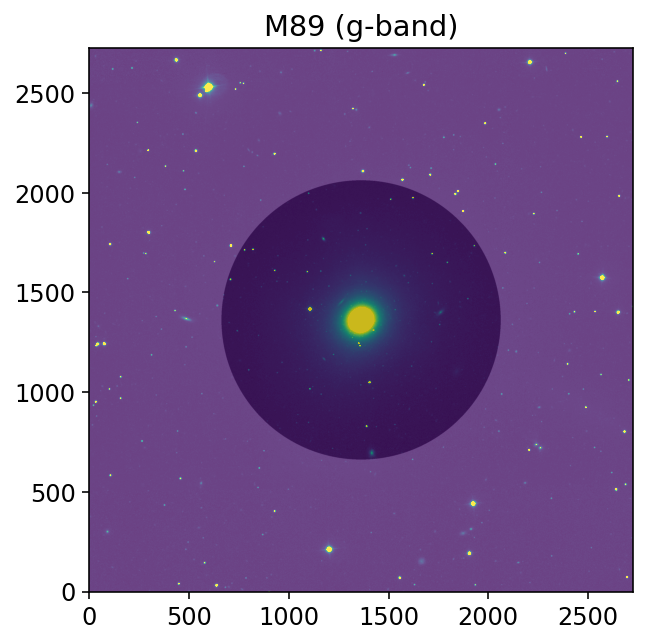

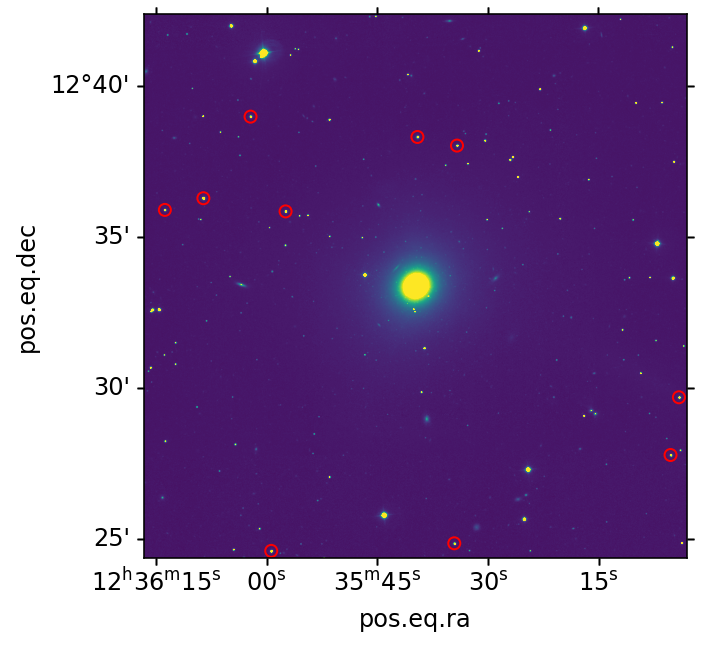

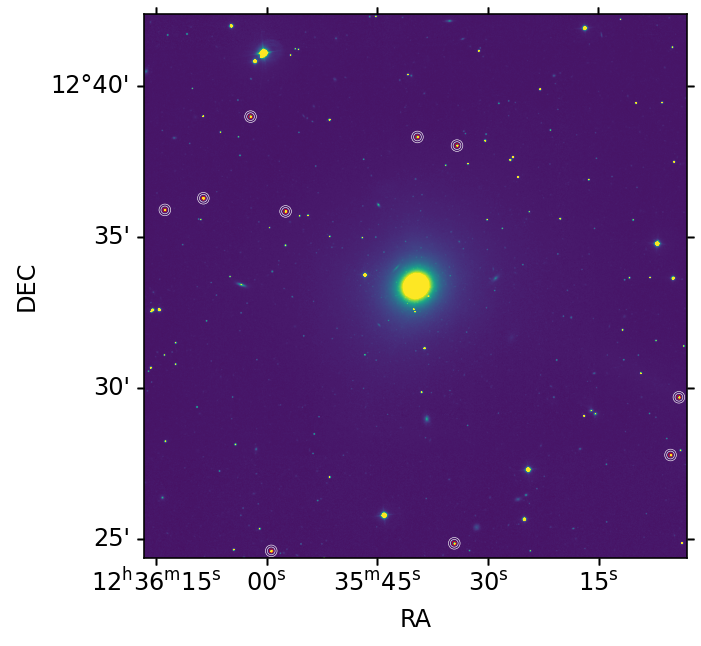

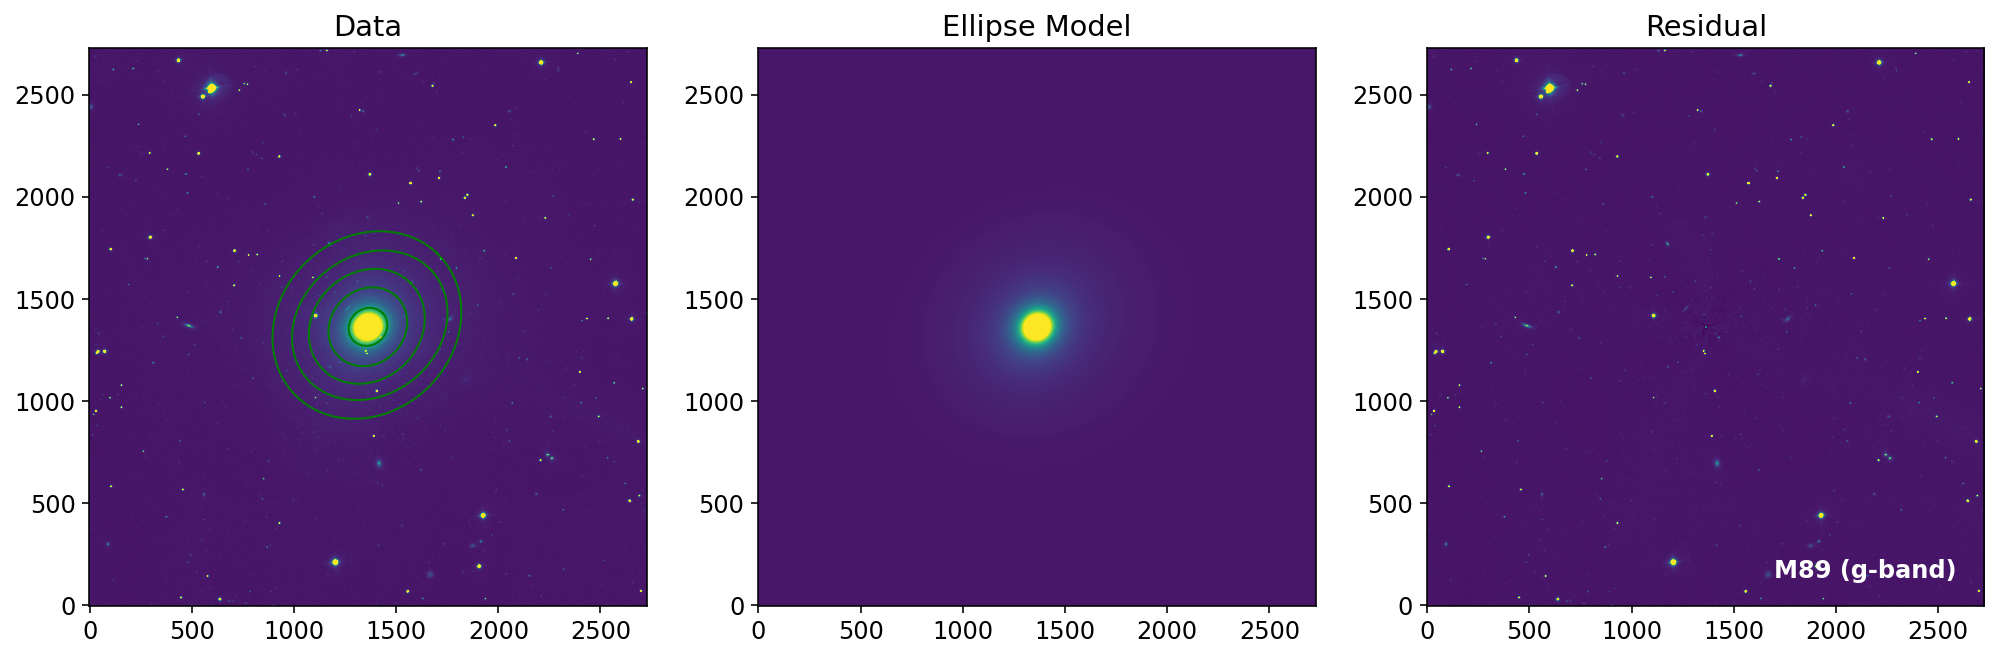

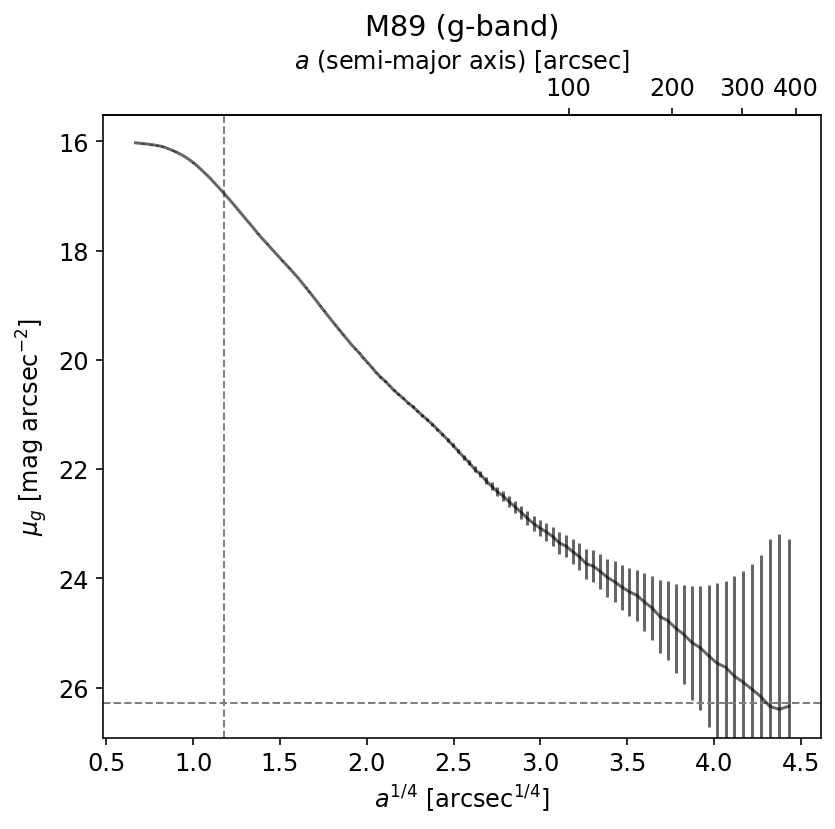

In [8]:
m89_g.set_radial_profile()
m89_g.fit_radial_profile(double=False)

In [ ]:
# let's do ellipse photometry for other images
m89_r = SloanGalaxySurfacePhot(imglist[1], 700, pixel_scale, 'M89', 'r')

m89_r.set_image()
m89_r.set_ref_stars(maglimit=16.5, display=True)
m89_r.apphot_stars()
print('estimated magnitude zeropoint:', np.mean(m89_r.get_mag0()))
m89_r.set_kwargs_simple()
print('Start: ' + time.ctime())
m89_r.ellipse()
m89_r.set_radial_profile()
m89_r.fit_radial_profile(double=False)
    
for m89_r in [m89_g, m89_r]:
    m89_r.display_radial_profile()

# color profile
display_color_profile(m89_g, m89_r, 'M89')

# profiles of various structure properties
for prop in ['eps', 'pa', 'a4', 'b4', 'a3', 'b3']:
    display_profile_prop(prop, m89_g, m89_r, 'M89', WD/'fig')
    
#%%
for m89_r in [m89_g, m89_r]:
    tflux = m89_r.isolist.tflux_e[-1]
    mag = m89_r.flux2mag(tflux)
    mag_err = 2.5*np.sqrt(tflux)/tflux/np.log(10)
    # npix_e = m89_r.isolist.npix_e[-1]
    # mag_err = 2.5*np.sqrt(tflux+npix_e*m89_r.sky_sig**2)/tflux/np.log(10)
    print(f'${mag:.3f}\pm{mag_err:.3f}$')